# Analysys of predicted free energies versus experimental measures during COVID Moonshot sprints
The aim of this notebook is to analyze retrospectively the accuracies of free energy calculations of Moonshot sprints to see if there was an increase over time and whether certain choices (protonation states, restraints) were effective or not. 

In [1]:
import scipy
import sklearn
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import json
import seaborn as sns
import urllib.request

In [2]:
def pIC50(IC50_series):
    return -np.log10(IC50_series.astype(float) * 1e-6)

def DeltaG(pIC50):
    kT = 0.593 # kcal/mol for 298 K (25C)
    return - kT * np.log(10.0) * pIC50

def dG_pIC50(dG):
    kT = 0.593 # kcal/mol for 298 K (25C)
    return dG / np.log(10.0) / (- kT)


In [3]:
def get_expt_measures(json_path):
    """From a JSON file, parse experimental measures."""
    
    with urllib.request.urlopen(json_path) as url:
        input_json = json.load(url)
        
    measures = {}
    for cpd in input_json["series"]["compounds"]:
        try:
            measures[cpd["metadata"]["compound_id"]] = [cpd["metadata"]["smiles"],
                                                        cpd["free_energy"]["point"], 
                                                        DeltaG(cpd["metadata"]["experimental_data"]["pIC50"]) ]
            
        except (KeyError, TypeError): # compound has no pred or experimental measure
            pass
    return measures

In [4]:
def plot_scatter(df, split_on=False):
    """Plot a scatter of pred vs expt DG, optionally splitting on sprint number, prot state or restraint form."""
    if not split_on:
        ax = sns.scatterplot(x="pred_dg", y="expt_dg", hue="sprint", data=df)

        ax.plot([-100,100], [-100,100], ls="--", zorder=-5, color="black")

        # some formatting.
        ax.set_xlabel("Predicted $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$")
        ax.set_ylabel("Measured $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$") 

        ax.set_xlim(-20, -2.5)
        ax.set_ylim(-20, -2.5)
        ax.set_title(f"All sprints combined")

    else:
        f, axes = plt.subplots(4,2, figsize=(10,20))
        for (sprint, df_grouped), ax in zip(df.groupby("sprint"), axes.flatten()):
            sns.scatterplot(x="pred_dg", y="expt_dg", hue=split_on, data=df_grouped, ax=ax)

            ax.plot([-100,100], [-100,100], ls="--", zorder=-5, color="black")

            # some formatting.
            ax.set_xlabel("Predicted $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$")
            ax.set_ylabel("Measured $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$") 

            ax.set_xlim(-20, 0)
            ax.set_ylim(-20, 0)
            ax.set_title(f"Sprint {sprint}")
        plt.tight_layout()
        plt.show()

In [5]:
# get all urls to JSON files.
json_urls = [
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-4/2020-09-06-ugi-tBu-x3110-3v3m-2020-04-Jacobs/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-5/sprint-5-stereofix-x11498-monomer-neutral/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-5/sprint-5-stereofix-x11498-dimer-neutral/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-9/sprint-9-2021-06-14-x10959-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-9/sprint-9-2021-06-14-x10959-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11A/sprint-11A-P1800_0A-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11A/sprint-11A-P1800_0A-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11A/sprint-11A-P1800_0A-dimer-charged-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11A/sprint-11A-P1800_0A-dimer-charged-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-12/sprint-12-P2385_0A-dimer-His41pos-Cys145neg-His163neutral/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-12/sprint-12-P2385_0A-dimer-His41pos-Cys145neg-His163pos/analysis.json",  
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-5/sprint-5-x12073-monomer-neutral/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-7/sprint-7-2021-05-11-stereofilter-P0033-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-8/sprint-8-2021-05-30-P0157-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-10/sprint-10-2021-07-26-x10959-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-10/sprint-10-2021-07-26-x10959-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-charged-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-charged-restrained/analysis.json",
]


# create a large dataframe of all predictions that have experimental data.
collective = []
for json_path in json_urls:
    # get sprint info.
    sprint_details = json_path.split("/")[5]
    sprint_num = sprint_details.split("-")[1]
    prot_state = sprint_details.split("-")[-2]
    restrain = sprint_details.split("-")[-1]
    
    if "dimer" in json_path:
        system = "dimer"
    else: # only sprint 4 has no definition of this - assume monomer.
        system = "monomer"

    # some manual adjustments.
    if prot_state == "monomer" or prot_state == "dimer": # sprint 5 has different url formatting.
        prot_state = "neutral"
        restrain = "restrained" # assumption.
    if "Jacobs" in sprint_details:
        sprint_num, prot_state, restrain = 4, "neutral", "restrained" # assumption.
    elif prot_state == "Cys145neg":
        prot_state = "charged"
        restrain = "restrained" # assumption.        
        
    print(sprint_num, prot_state, restrain, system)

   
    # get pred DG and expt DG from the JSON file.
    sprint_expt_dict = get_expt_measures(json_path)
    if len(sprint_expt_dict) == 0:
        continue # skip the empty sprint 7.
        
    # add all into one DF.
    sprint_df = pd.DataFrame.from_dict(sprint_expt_dict, orient="index")
    sprint_df.columns = ["smiles", "pred_dg", "expt_dg"]
    sprint_df["sprint"] = sprint_num
    sprint_df["protonation_state"] = prot_state
    sprint_df["restrain_form"] = restrain
    sprint_df["system_form"] = system
    
    # add to bucket. 
    collective.append(sprint_df)
    
all_sprints_df = pd.concat(collective)  
all_sprints_df 

4 neutral restrained monomer
5 neutral restrained monomer
5 neutral restrained dimer
9 neutral restrained dimer
9 neutral unrestrained dimer
11A neutral unrestrained dimer
11A neutral restrained dimer
11A charged unrestrained dimer
11A charged restrained dimer
12 charged restrained dimer
12 charged restrained dimer
5 neutral restrained monomer
7 neutral restrained dimer
8 neutral restrained dimer
10 neutral restrained dimer
10 neutral unrestrained dimer
11 neutral unrestrained dimer
11 neutral restrained dimer
11 charged unrestrained dimer
11 charged restrained dimer


,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form,system_form
3v3m-2020-04-Jacobs,CC(C)(C)c1ccc(cc1)N([C@H](c2cccnc2)C(=O)NC(C)(...,-11.865403,-7.513278,4,neutral,restrained,monomer
LON-WEI-2e27a2e5-1,CC(C)(C)c1ccc(cc1)N([C@H](c2cccnc2)C(=O)NCCc3c...,-12.585684,-7.641425,4,neutral,restrained,monomer
EDJ-MED-e4b030d8-13,C[C@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4,-16.096731,-8.939836,5,neutral,restrained,monomer
EDJ-MED-e4b030d8-11,C[C@H]1COc2ccc(cc2[C@@H]1C(=O)Nc3cncc4c3cccc4)Cl,-16.792675,-9.248166,5,neutral,restrained,monomer
VLA-UCB-1dbca3b4-15,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3cc(cc4)Cl,-15.083394,-8.799289,5,neutral,restrained,monomer
...,...,...,...,...,...,...,...
MAT-POS-853c0ffa-16,COC1(CC1)CS(=O)(=O)N2Cc3ccc(cc3C4(C2)CCN(C4=O)...,-14.074481,-8.716992,11,charged,restrained,dimer
ALP-POS-ecbed2ba-2,c1ccc2c(c1)cncc2N3CCC4(C3=O)CN(Cc5c4cc(cc5)Cl)...,-15.133608,-9.115245,11,charged,restrained,dimer
MAT-POS-853c0ffa-9,CN(C)CCOc1ccc2cncc(c2c1)N3CCC4(C3=O)CN(Cc5c4cc...,-16.331530,-9.275624,11,charged,restrained,dimer
MAT-POS-853c0ffa-10,CN(C)CCOc1ccc2cncc(c2c1)N3CCC4(C3=O)CN(Cc5c4cc...,-15.585297,-9.206188,11,charged,restrained,dimer


In [6]:
# sort by sprint so plots are easier to follow chronologically.
def sprint_sorter(column):
    """Sort function"""
    sprints = ["4", '5', '8', '9', '10', '11', '11A', '12']
    correspondence = {sprnt: order for order, sprnt in enumerate(sprints)}
    return column.map(correspondence)

all_sprints_df = all_sprints_df.sort_values(by='sprint', key=sprint_sorter)
# this doesn't quite work because we have the pesky sprint 11A, so mixed types. If we merge 11 and 11A we 
# could sort the plots more nicely.

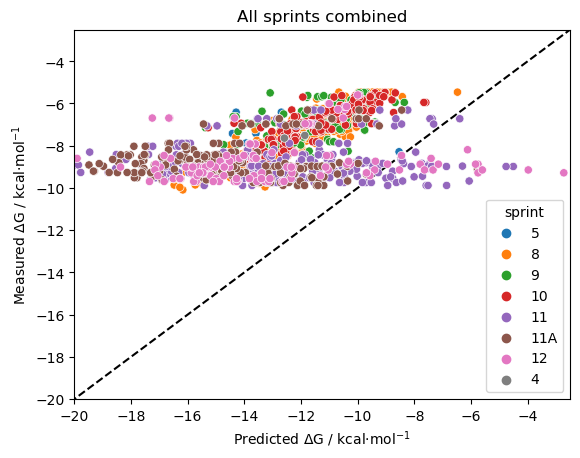

In [7]:
# plot all sprints overlaid
plot_scatter(all_sprints_df)

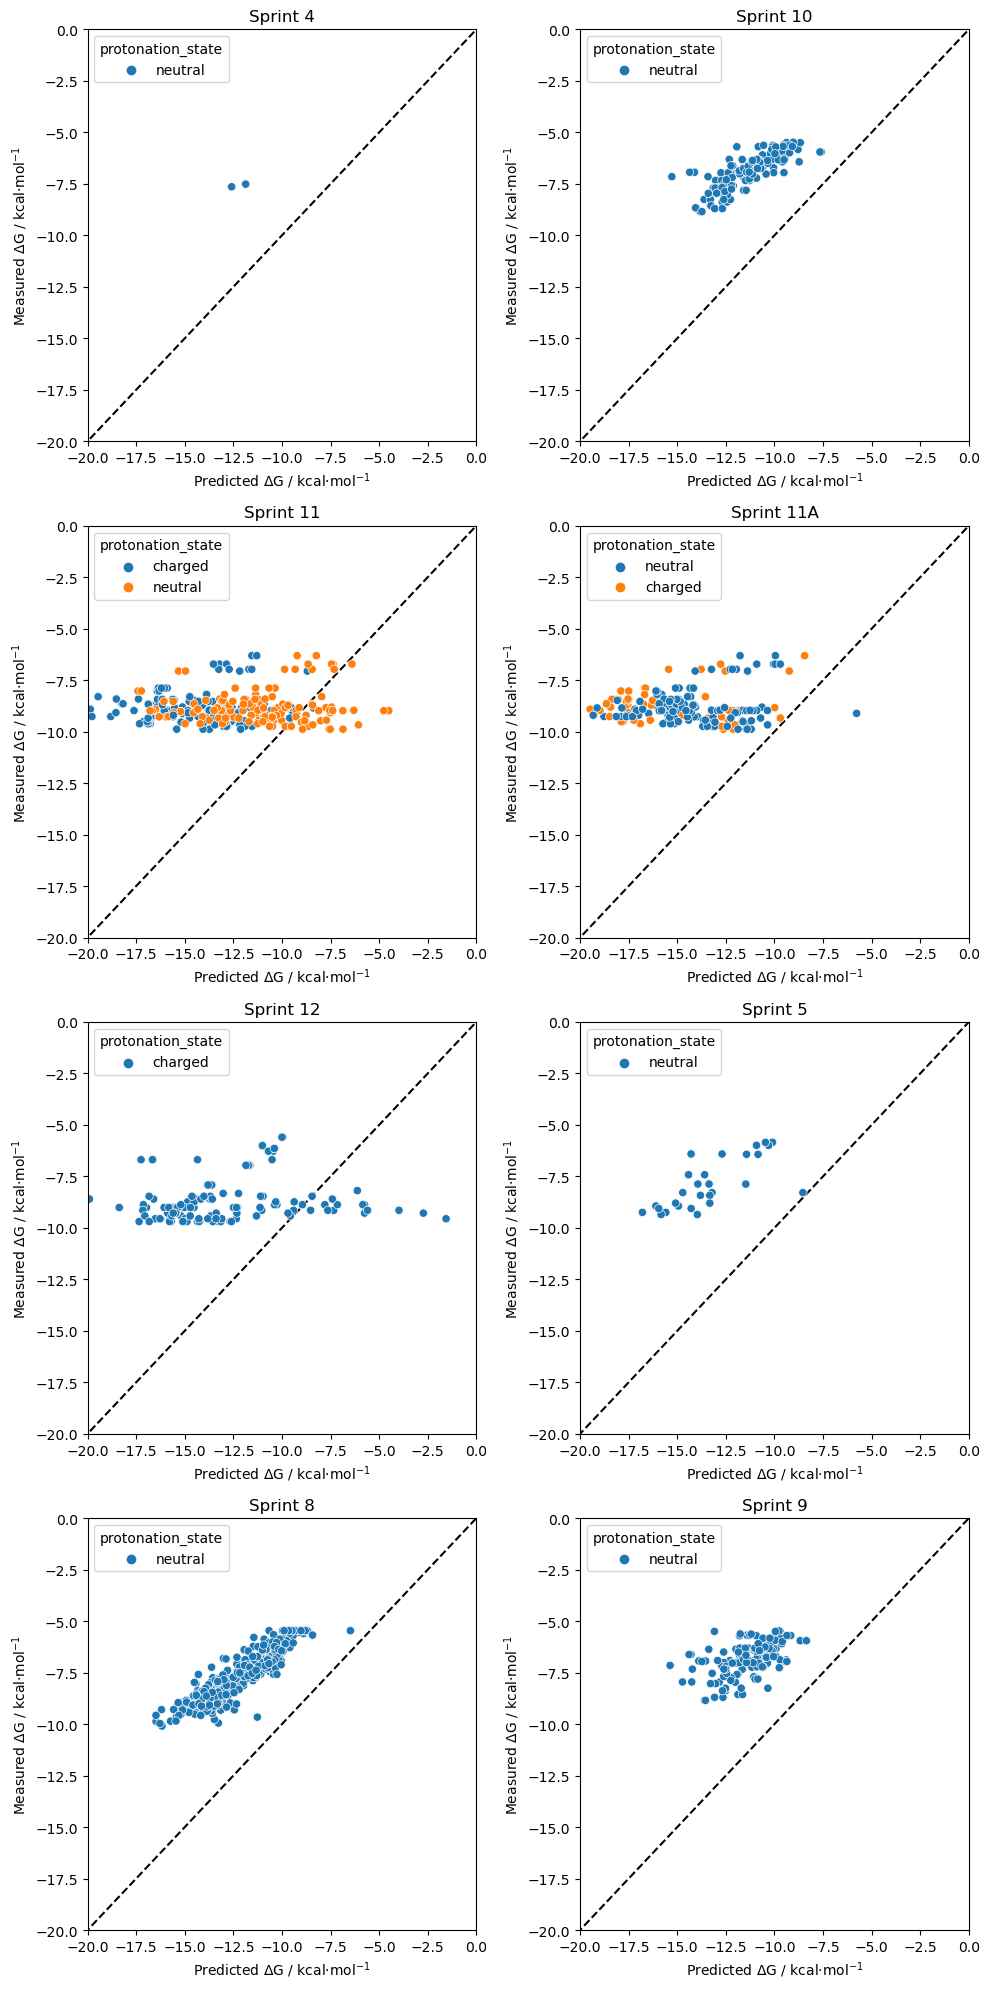

In [8]:
# plot all sprints separately while splitting by protonation state
plot_scatter(all_sprints_df, split_on="protonation_state")

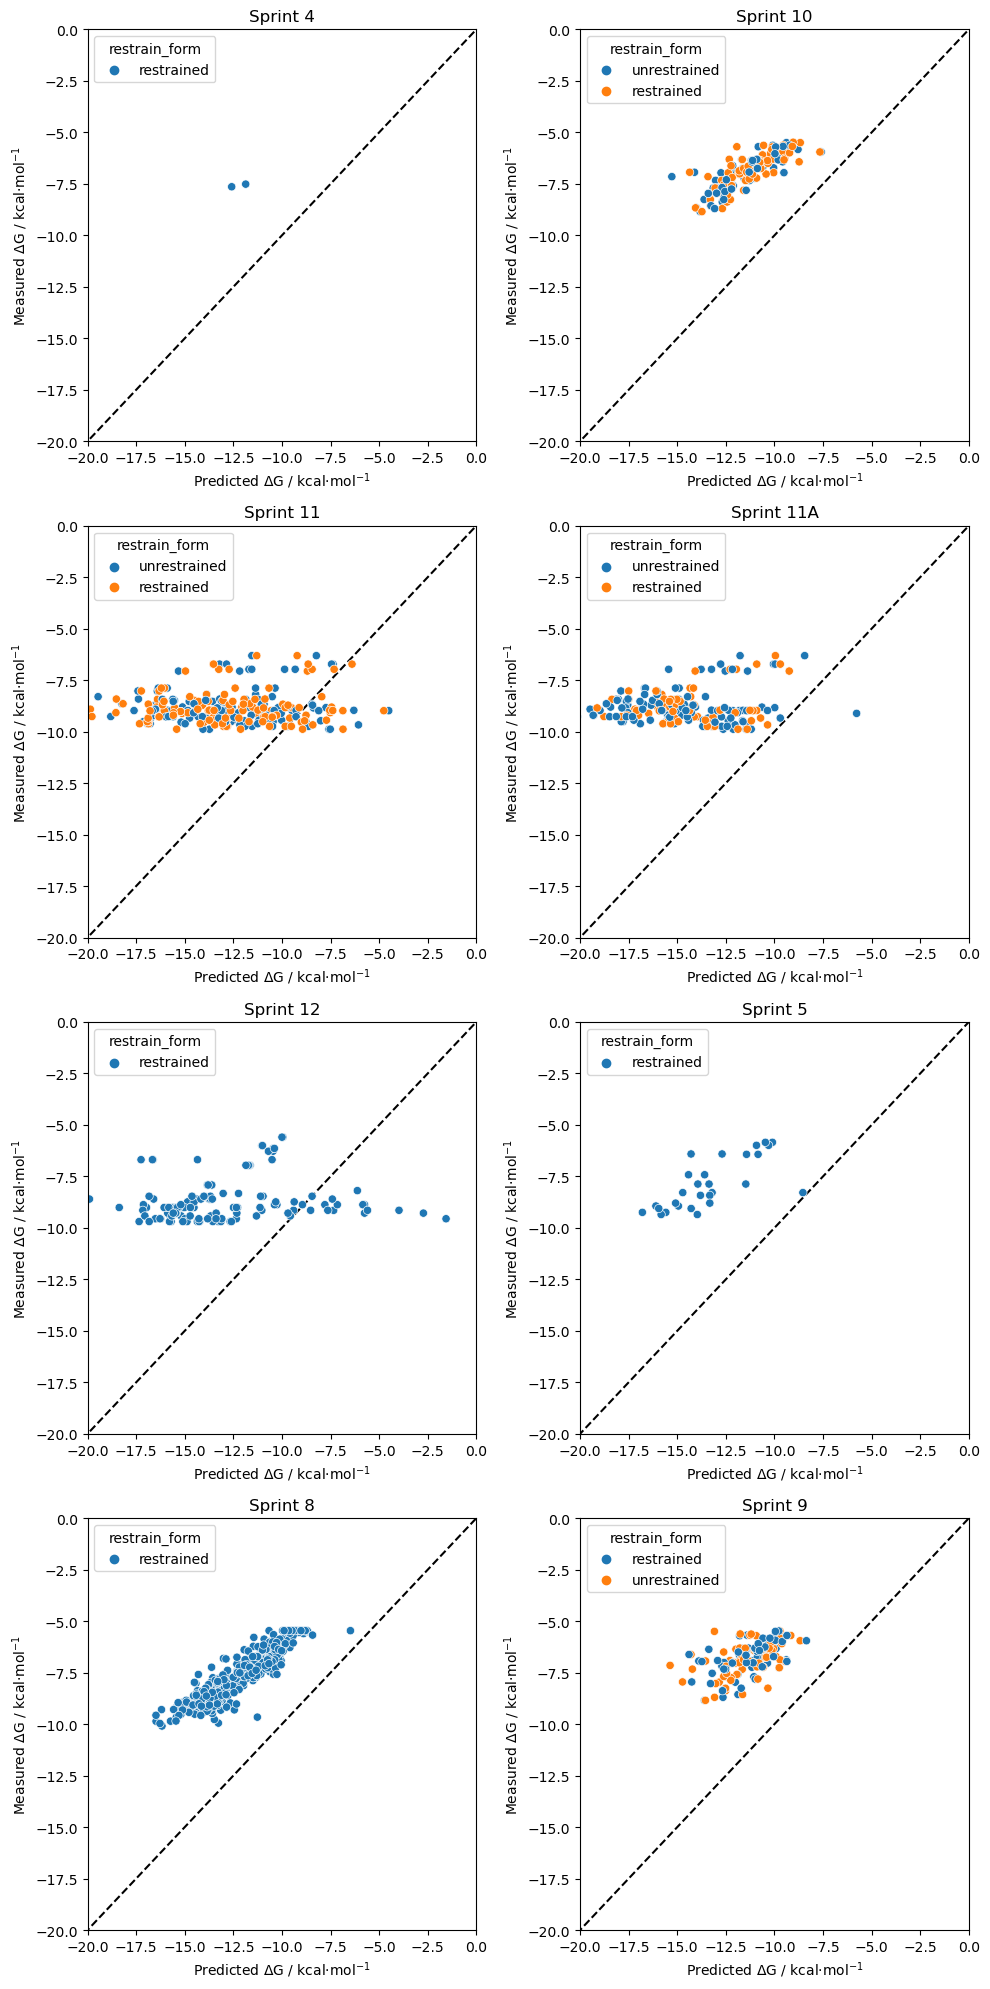

In [9]:
# plot all sprints separately while splitting by restraint form
plot_scatter(all_sprints_df, split_on="restrain_form")

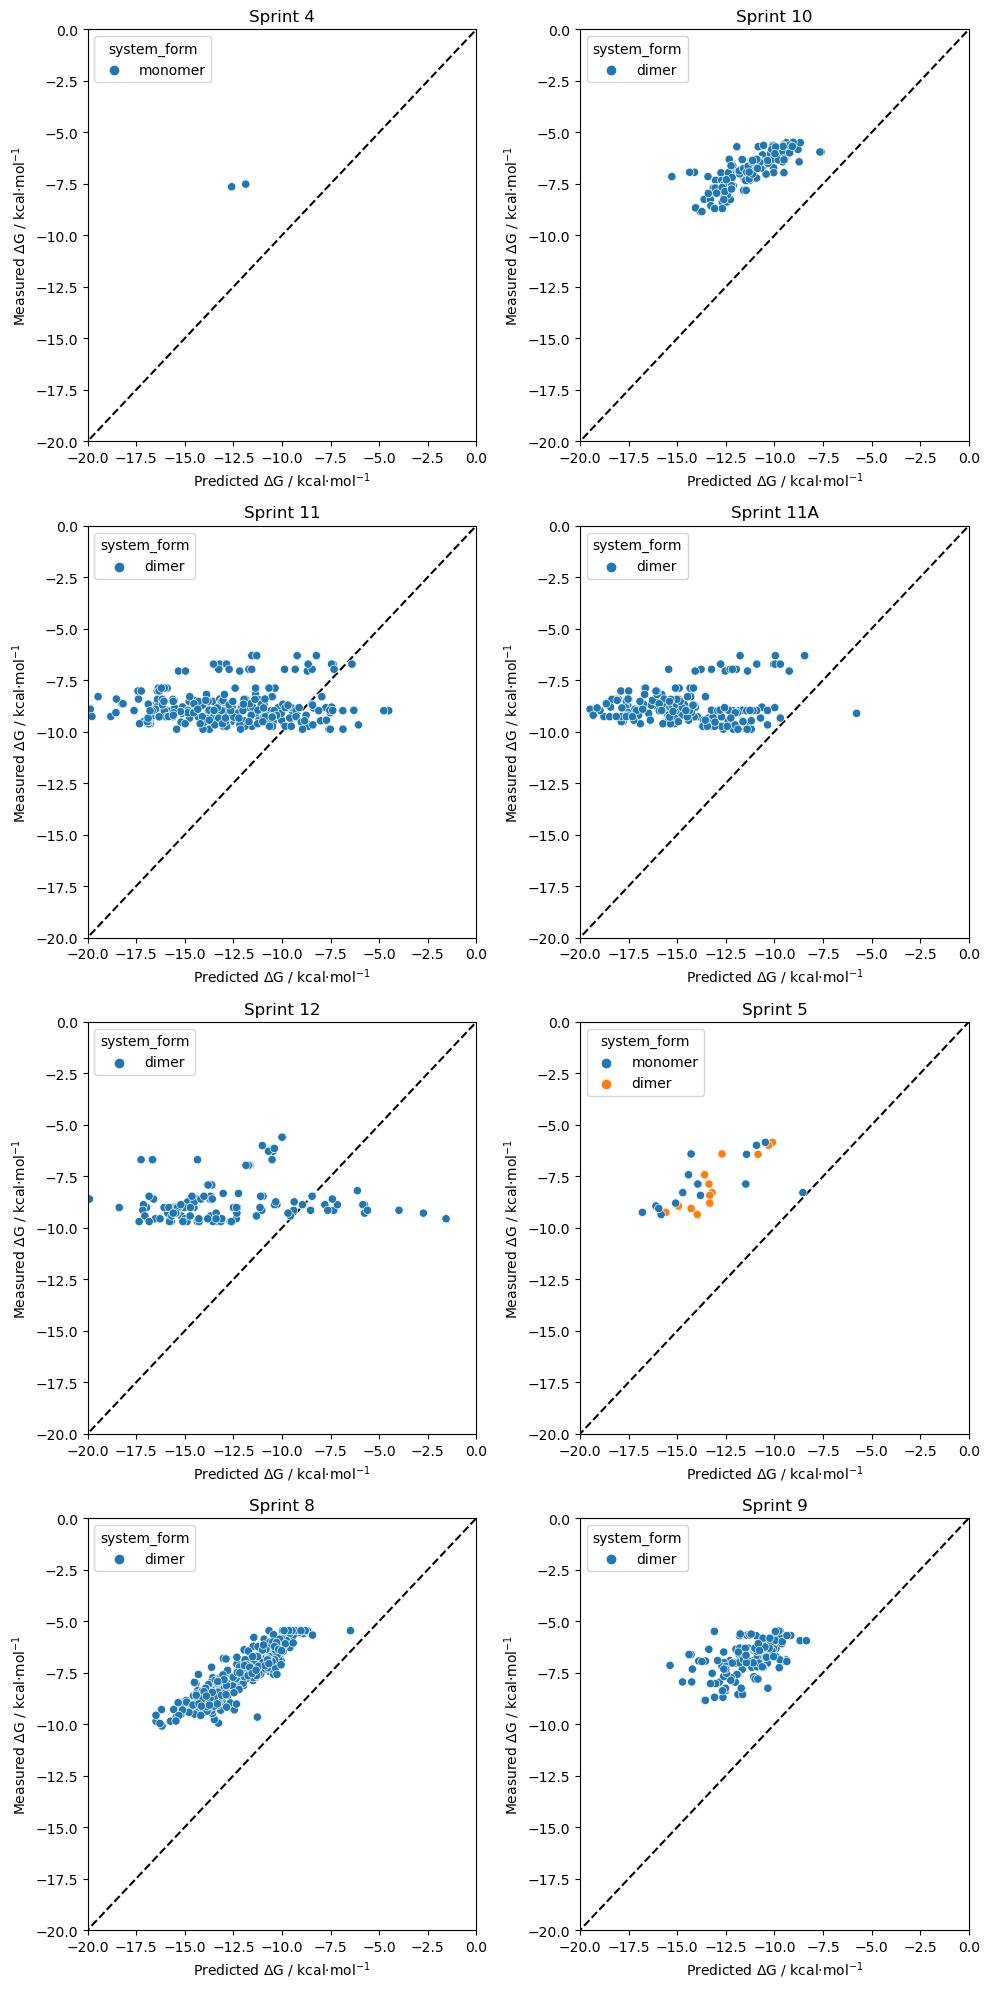

In [10]:
# plot all sprints separately while splitting by restraint form
plot_scatter(all_sprints_df, split_on="system_form")

## Fancy plotting with Cinnabar

In [11]:
from cinnabar import plotting # cloned https://github.com/OpenFreeEnergy/cinnabar locally but did not commit.

In [12]:
def dG_pIC50(dG):
    # convert DG to pIC50 using Cheng-Prusoff to correct for substrate.
    kT = 0.593 # kcal/mol for 298 K (25C)
    S = 375e-9
    Km = 9.5e-6
    Ki = np.exp(dG/kT)
    IC50 = Ki * (1 + S / Km)
    pIC50 = -np.log10(IC50)
    return pIC50

In [13]:
# get pIC50s for both pred and expt columns.
all_sprints_df["pred_pic50"] = [ dG_pIC50(dG) for dG in all_sprints_df["pred_dg"] ]
all_sprints_df["expt_pic50"] = [ dG_pIC50(dG) for dG in all_sprints_df["expt_dg"] ]

all_sprints_df

,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form,system_form,pred_pic50,expt_pic50
EDJ-MED-e4b030d8-13,C[C@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4,-16.096731,-8.939836,5,neutral,restrained,monomer,11.771924,6.530440
MAT-POS-11b63608-1,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3cc(cc4)Br,-8.539094,-8.288342,5,neutral,restrained,monomer,6.236950,6.053307
MAT-POS-8a69d52e-3,C[C@H]1C[C@@H](c2cc(ccc2O1)Cl)C(=O)Nc3cncc4c3c...,-10.104850,-5.848706,5,neutral,restrained,dimer,7.383659,4.266594
EDJ-MED-e4b030d8-3,C[C@H]1C[C@H](c2cc(ccc2O1)Cl)C(=O)Nc3cncc4c3cccc4,-12.694385,-6.413860,5,neutral,restrained,dimer,9.280153,4.680495
MAT-POS-8e4737f4-1,C[C@@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4,-10.843495,-6.431194,5,neutral,restrained,dimer,7.924620,4.693190
...,...,...,...,...,...,...,...,...,...
MAT-POS-be048f2c-5,CCn1c(ccn1)C(=O)N2Cc3ccc(cc3C4(C2)CCN(C4=O)c5c...,-15.201502,-8.875314,12,charged,restrained,dimer,11.116286,6.483187
ALP-POS-ecbed2ba-13,CC(C)(CS(=O)(=O)N1Cc2ccc(cc2C3(C1)CCN(C3=O)c4c...,-7.410495,-8.602228,12,charged,restrained,dimer,5.410399,6.283187
MAT-POS-69786b79-1,CNC(=O)C1(CC1)N2Cc3ccc(cc3C4(C2)CCN(C4=O)c5cnc...,-12.600879,-9.694574,12,charged,restrained,dimer,9.211672,7.083187
3v3m-2020-04-Jacobs,CC(C)(C)c1ccc(cc1)N([C@H](c2cccnc2)C(=O)NC(C)(...,-11.865403,-7.513278,4,neutral,restrained,monomer,8.673033,5.485674


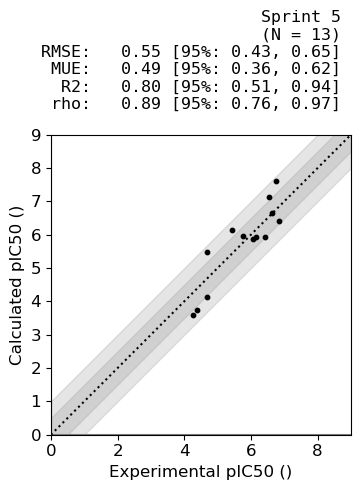

In [25]:
# first do sprint 5. For all plots we'll want [restrained, dimer, neutral].
sprint_for_plot = all_sprints_df[all_sprints_df["sprint"] == "5"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["restrain_form"] == "restrained"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["system_form"] == "dimer"]
sprint_for_plot_5 = sprint_for_plot[sprint_for_plot["protonation_state"] == "neutral"]

# shift the additive mean of predicted to experimental to make deviation statistics meaningful.
mean_difference = sprint_for_plot_5["pred_pic50"].mean() - sprint_for_plot_5["expt_pic50"].mean()
sprint_for_plot_5["pred_pic50"] = [ val - mean_difference for val in sprint_for_plot_5["pred_pic50"] ]


plot = plotting._master_plot(x=sprint_for_plot_5["expt_pic50"], y=sprint_for_plot_5["pred_pic50"], 
                            figsize=5,
                            title="Sprint 5",
                            quantity="pIC50",
                            units="",
                            xy_lim=[0, 9],
                            color="black",
                            statistics=["RMSE", "MUE", "R2", "rho"],
                            filename="sprint_5.png")



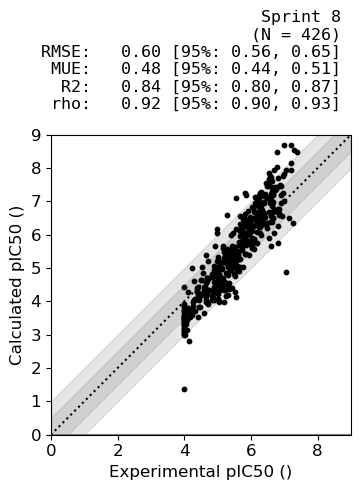

In [26]:
# Rinse + repeat
sprint_for_plot = all_sprints_df[all_sprints_df["sprint"] == "8"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["restrain_form"] == "restrained"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["system_form"] == "dimer"]
sprint_for_plot_8 = sprint_for_plot[sprint_for_plot["protonation_state"] == "neutral"]

# shift the additive mean of predicted to experimental to make deviation statistics meaningful.
mean_difference = sprint_for_plot_8["pred_pic50"].mean() - sprint_for_plot_8["expt_pic50"].mean()
sprint_for_plot_8["pred_pic50"] = [ val - mean_difference for val in sprint_for_plot_8["pred_pic50"] ]


plot = plotting._master_plot(x=sprint_for_plot_8["expt_pic50"], y=sprint_for_plot_8["pred_pic50"], 
                            figsize=5,
                            title="Sprint 8",
                            quantity="pIC50",
                            units="",
                            xy_lim=[0, 9],
                            color="black",
                            statistics=["RMSE", "MUE", "R2", "rho"],
                            filename="sprint_8.png")

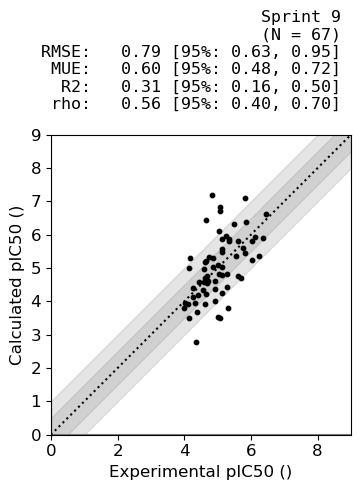

In [27]:
# first do sprint 5. For all plots we'll want [restrained, dimer, neutral].
sprint_for_plot = all_sprints_df[all_sprints_df["sprint"] == "9"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["restrain_form"] == "restrained"]
sprint_for_plot = sprint_for_plot[sprint_for_plot["system_form"] == "dimer"]
sprint_for_plot_9 = sprint_for_plot[sprint_for_plot["protonation_state"] == "neutral"]

# shift the additive mean of predicted to experimental to make deviation statistics meaningful.
mean_difference = sprint_for_plot_9["pred_pic50"].mean() - sprint_for_plot_9["expt_pic50"].mean()
sprint_for_plot_9["pred_pic50"] = [ val - mean_difference for val in sprint_for_plot_9["pred_pic50"] ]


plot = plotting._master_plot(x=sprint_for_plot_9["expt_pic50"], y=sprint_for_plot_9["pred_pic50"], 
                            figsize=5,
                            title="Sprint 9",
                            quantity="pIC50",
                            units="",
                            xy_lim=[0, 9],
                            color="black",
                            statistics=["RMSE", "MUE", "R2", "rho"],
                            filename="sprint_9.png")

### will do final edits with adobe PS.

In [31]:
# get some SMILES for sprints 5, 8 and 9 to figure out the R groups on the sprints' scaffolds.
sprint_for_plot_5.sort_values("expt_pic50", ascending=False)

,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form,system_form,pred_pic50,expt_pic50
MAT-POS-b3e365b9-1,c1ccc2c(c1)cncc2NC(=O)[C@@H]3CCOc4c3cc(cc4)Cl,-13.967369,-9.353516,5,neutral,restrained,dimer,6.412811,6.833407
EDJ-MED-e4b030d8-11,C[C@H]1COc2ccc(cc2[C@@H]1C(=O)Nc3cncc4c3cccc4)Cl,-15.587328,-9.248166,5,neutral,restrained,dimer,7.599218,6.756251
EDJ-MED-e4b030d8-2,C[C@@H]1C[C@H](c2cc(ccc2O1)Cl)C(=O)Nc3cncc4c3c...,-14.284743,-9.060769,5,neutral,restrained,dimer,6.645246,6.619008
EDJ-MED-e4b030d8-13,C[C@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4,-14.939426,-8.939836,5,neutral,restrained,dimer,7.124715,6.530440
VLA-UCB-1dbca3b4-15,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3cc(cc4)Cl,-13.325305,-8.799289,5,neutral,restrained,dimer,5.942584,6.427508
MAT-POS-8a69d52e-2,C[C@@H]1C[C@@H](c2cc(ccc2O1)Cl)C(=O)Nc3cncc4c3...,-13.327420,-8.421915,5,neutral,restrained,dimer,5.944133,6.151131
MAT-POS-11b63608-1,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3cc(cc4)Br,-13.209078,-8.288342,5,neutral,restrained,dimer,5.857463,6.053307
MAT-POS-8a69d52e-7,C[C@@H]1COc2ccc(cc2[C@@H]1C(=O)Nc3cncc4c3cccc4)Cl,-13.365103,-7.873249,5,neutral,restrained,dimer,5.971731,5.749305
EDJ-MED-e4b030d8-8,Cc1c(ccc2c1[C@@H](CCO2)C(=O)Nc3cncc4c3cccc4)Cl,-13.590841,-7.421777,5,neutral,restrained,dimer,6.137054,5.418661
MAT-POS-8e4737f4-1,C[C@@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4,-10.843495,-6.431194,5,neutral,restrained,dimer,4.124984,4.693190


In [40]:
# get row for the reference used.
sprint_for_plot_5.loc["MAT-POS-b3e365b9-1"]

smiles               c1ccc2c(c1)cncc2NC(=O)[C@@H]3CCOc4c3cc(cc4)Cl
pred_dg                                                 -13.967369
expt_dg                                                  -9.353516
sprint                                                           5
protonation_state                                          neutral
restrain_form                                           restrained
system_form                                                  dimer
pred_pic50                                                6.412811
expt_pic50                                                6.833407
Name: MAT-POS-b3e365b9-1, dtype: object

In [32]:
sprint_for_plot_8.sort_values("expt_pic50", ascending=False)

,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form,system_form,pred_pic50,expt_pic50
MAT-POS-e69ad64a-2,C=CC(=O)N(c1cncc2c1cccc2)C(=O)C3COc4c3cc(cc4)Cl,-16.169857,-10.093302,8,neutral,restrained,dimer,8.472400,7.375202
MAT-POS-f9802937-8,c1ccc2c(c1)cncc2NC(=O)[C@@H]3CCNc4c3cc(c(c4)Cl)Cl,-16.273522,-9.969067,8,neutral,restrained,dimer,8.548321,7.284216
MAT-POS-4223bc15-11,CC1CCN(C1)S(=O)(=O)N2Cc3ccc(cc3C(C2)C(=O)Nc4cn...,-13.269033,-9.950891,8,neutral,restrained,dimer,6.347928,7.270905
MAT-POS-4223bc15-12,c1ccc2c(c1)cncc2NC(=O)C3CN(Cc4c3cc(cc4)Cl)S(=O...,-16.474450,-9.862335,8,neutral,restrained,dimer,8.695474,7.206049
MAT-POS-ec6d90b7-6,COc1ccc2cncc(c2c1)NC(=O)[C@H]3CCNc4c3cc(c(c4)C...,-15.730952,-9.856621,8,neutral,restrained,dimer,8.150960,7.201865
...,...,...,...,...,...,...,...,...,...
MAT-POS-90505e2b-1,c1ccc2c(c1)cncc2N3C(=O)C4(CCOc5c4cc(cc5)Cl)OC3=O,-9.023574,-5.464704,8,neutral,restrained,dimer,3.238688,3.985363
JOH-UNI-f51e3bbc-1,c1ccc2c(c1)c(c[nH]c2=O)NC(=O)C3CCOc4c3cc(cc4)Cl,-9.102450,-5.464704,8,neutral,restrained,dimer,3.296454,3.985363
ALP-UNI-4b8a177c-1,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3c(ccc4O)Cl,-8.948278,-5.464704,8,neutral,restrained,dimer,3.183543,3.985363
ALP-POS-c3a96089-2,Cc1ccc(nc1)N(Cc2cscn2)C(=O)Cc3cncc4c3cccc4,-9.291238,-5.464704,8,neutral,restrained,dimer,3.434717,3.985363


In [38]:
# get row for the reference used.
sprint_for_plot_8.loc["PET-UNK-29afea89-2"]

smiles               CO[C@]1(CCOc2c1cc(cc2)Cl)C(=O)Nc3cncc4c3cccc4
pred_dg                                                 -11.265511
expt_dg                                                  -9.661676
sprint                                                           8
protonation_state                                          neutral
restrain_form                                           restrained
system_form                                                  dimer
pred_pic50                                                4.880612
expt_pic50                                                7.059093
Name: PET-UNK-29afea89-2, dtype: object

In [33]:
sprint_for_plot_9.sort_values("expt_pic50", ascending=False)

,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form,system_form,pred_pic50,expt_pic50
MIC-UNK-50cce87d-3,Cc1cccc2c1c(cnc2)NC(=O)Cc3cccc(c3)Cl,-13.599330,-8.847569,9,neutral,restrained,dimer,6.610561,6.462867
JIN-POS-6dc588a4-22,c1cc(cc(c1)Cl)CC(=O)Nc2cncc3c2ccs3,-12.647870,-8.700612,9,neutral,restrained,dimer,5.913742,6.355240
RUB-POS-1325a9ea-4,Cc1ccc2cncc(c2c1)NC(=O)Cc3cccc(c3)Cl,-11.877170,-8.561209,9,neutral,restrained,dimer,5.349306,6.253146
ADA-UCB-6c2cb422-1,c1ccc2c(c1)cncc2NC(=O)Cc3cccc(c3)Cl,-12.671139,-8.380694,9,neutral,restrained,dimer,5.930783,6.120942
JIN-POS-6dc588a4-13,c1cc(cc(c1)Cl)CC(=O)Nc2cncc3c2cccc3F,-12.525874,-8.261994,9,neutral,restrained,dimer,5.824395,6.034010
...,...,...,...,...,...,...,...,...,...
MIC-UNK-08cd9c58-1,c1cc(cc(c1)Cl)CC(=O)Nc2cncc3c2cccn3,-9.359262,-5.698221,9,neutral,restrained,dimer,3.505269,4.156384
RUB-POS-1325a9ea-20,c1ccc2c(c1)COCC2NC(=O)Cc3cccc(c3)Cl,-11.413962,-5.682185,9,neutral,restrained,dimer,5.010067,4.144639
EDJ-MED-c8e7a002-4,Cc1ccn2cnnc2c1NC(=O)Cc3cccc(c3)Cl,-9.943642,-5.630296,9,neutral,restrained,dimer,3.933251,4.106637
PET-UNK-8df914d1-4,Cn1cncc1NC(=O)Cc2cccc(c2)Cl,-9.951215,-5.499157,9,neutral,restrained,dimer,3.938796,4.010595


In [42]:
# get row for the reference used.
sprint_for_plot_9.loc["ADA-UCB-6c2cb422-1"]

smiles               c1ccc2c(c1)cncc2NC(=O)Cc3cccc(c3)Cl
pred_dg                                       -12.671139
expt_dg                                        -8.380694
sprint                                                 9
protonation_state                                neutral
restrain_form                                 restrained
system_form                                        dimer
pred_pic50                                      5.930783
expt_pic50                                      6.120942
Name: ADA-UCB-6c2cb422-1, dtype: object